In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob # 대량의 파일을 다룰때 편리한 라이브러리

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential

In [2]:
MY_GEN = 128 # 생성자 은닉층의 각각의 뉴런의 수
MY_DIS = 128 # 감별자 은닉층의 뉴런 수
MY_NOISE = 100 # 생성자에 들어갈 노이즈 벡터안의 숫자 개수

MY_SHAPE = (28, 28, 1) # mnist 데이터 크기, 채널 정보 포함
MY_BATCH = 300
MY_EPOCH = 25000

In [3]:
my_folder = 'output/' # 생성자가 만들어낸 이미지 저장 경로
os.makedirs(my_folder, exist_ok=True) # exist_ok 는 같은 이름의 폴더가 존재하면 에러 메세지 띄우지 말고 계속 진행하라는 뜻
# false가 디폴트로 에러나면서 프로그램 종료됨

# output 디렉토리에 파일 전부 삭제
for f in glob.glob(my_folder + '*'):
    os.remove(f)

In [4]:
# 데이터 준비

# 넘파이 n차원 행렬로 리턴
def read_data():
    # 학습용 입력값만 사용 (GAN은 비지도 학습)
    (x_trian, _), (_, _) = mnist.load_data()
    
    print("데이터 모양: ", x_trian.shape)

    # plt.imshow(x_trian[0], cmap='gray')

    # [-1, 1] 구간으로 데이터 스케일링
    # LeakyRelu 나 tanh 같은 활성화 함수 사용할때 효과 좋음
    # 데이터 정규화 안하면 기울기 유실의 원인으로 작용할수도 
    x_trian = x_trian / 127.5 - 1.0

    # 채널 정보 추가
    x_trian = np.expand_dims(x_trian, axis=3) # 축은 0부터 시작해서 3을 입력함
    print("데이터 모양: ", x_trian.shape) # dense나 flatten에 들어갈 데이터 크기 맞춰줄라고

    return x_trian

In [5]:
# 생성자 설계

def build_generator():
    model = Sequential()

    model.add(Dense(MY_GEN, input_dim=MY_NOISE))
    model.add(LeakyReLU(alpha=0.01)) # 음수쪽의 기울기 설정

    model.add(Dense(MY_GEN))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(28*28*1, activation='tanh')) # tanh는 [-1, 1] 스케일링 때문

    # 28*28 크기의 이미지 데이터 모양으로 바꿔서 출력하는 층
    model.add(Reshape(MY_SHAPE))

    model.summary()
    
    return model

In [6]:
# 감별자 설계

def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=MY_SHAPE))

    model.add(Dense(MY_DIS))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    return model


In [7]:
# dnn-GAN 구현

def build_GAN():
    model = Sequential()

    # 생성자 구현
    generator = build_generator()

    # 감별자 구현
    # 생성자 학습시 감별자 고정
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['acc']
    )
    discriminator.trainable = False # 감별자의 가중치가 변하지 않도록 고정시키는 코드 >>> 가장 중요한 부분!!!


    # 실제 GAN 구현 : 생성자 먼저 추가, 그 다음 감별자 추가
    model.add(generator)
    model.add(discriminator)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy'

        # GAN은 정확도 무의미
    )

    model.summary()
    
    return discriminator, generator, model

In [8]:
# 인공신경망 학습

# 감별자 학습 방법
def train_discriminator(): # 감별자는 한 배치를 가져와서 훈련
    # 진짜 이미지 임의로 한 batch 추출
    total = x_train.shape[0] # 60000이라는 값이 저장됨
    random_batch_num = np.random.randint(0, total, MY_BATCH) # 범위와 개수 지정
    image = x_train[random_batch_num]

    # 숫자 1을 한 batch 생성
    all_1 = np.ones((MY_BATCH, 1)) # 2차원 배열 >> 정답 라벨용

    # 진짜 이미지로 감별자 한번 학습
    # 모델 훈련 함수로는 fit, fit_generator, train_on_batch 등이 있다.
    d_loss_real = discriminator.train_on_batch( # batch 하나의 데이터를 한번씩 훈련하면서 나온 각각의 손실값의 평균을 리턴, 가중치는 batch 하나에 1번만 보정
        image,
        all_1 # 위의 이미지는 진짜 이미지라고 학습할 수 있게 라벨을 넣어주는 것
        # 라벨을 넣어줬다고 해서 감별자의 학습이 지도 학습이라고 생각하면 틀린 것
        # 왜나하면 지도 학습일 경우에는 이미지가 무슨 숫자인지 맞추도록 라벨을 넣어줘야하기 때문
        # 하지만 all_1은 위의 이미지가 진짜 이미지라고 학습하도록 유도만 하는 것이다
    ) # >> d_loss_real 에는 2가지 숫자가 들어있는데 첫번째 숫자는 손실값이고, 다음 숫자는 정확도다

    # print(d_loss_real)

    # 생성자를 이용하여 가짜 이미지 생성
    # 노이즈 벡터는 표준 정규 분포를 사용
    noise = np.random.normal(0, 1, (MY_BATCH, MY_NOISE)) # 평균, 표준편차, 어떤 사이즈를 몇개를 원하는지
    # 위의 노이즈 벡터는 300, 100 크기의 2차원 numpy 행렬

    # 생성자로 가짜 이미지 생성
    fake_image = generator.predict(noise)
    # plt.imshow(fake_image[0])
    # print(fake_image.shape) # (300, 28, 28, 1)

    # 숫자 0으로 이루어진 한 batch 생성 >> 위의 all_1 처럼 라벨용
    all_0 = np.zeros((MY_BATCH, 1))

    d_loss_fake = discriminator.train_on_batch(fake_image, all_0)
    # print(d_loss_fake)

    # 평균 손실과 정확도 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 위의 평균값이 감별자의 현재 배치에 대한 최종 손실값

    # print(d_loss)

    return d_loss

In [9]:
# 생성자 학습 방법

def train_generator():
    # 노이즈벡터는 표준 정규분포를 사용
    noise = np.random.normal(0, 1, (MY_BATCH, MY_NOISE))

    # noise.shape = (300, 100)

    # 숫자 1을 한 batch 생성
    all_1 = np.ones((MY_BATCH, 1)) # all_1.shape = (300, 1)

    # 가짜 이미지로 생성자 한번 학습
    g_loss = gan.train_on_batch(noise, all_1)
    # 위 변수는 정확도가 안들어있고, 손실값만 들어있음
    # compile 함수에서 정확도를 안넣어줬기때문 >> 생성자는 정확도 무의미

    return g_loss
    


In [10]:
# 샘플 이미지 N x N 출력
def sample(epoch):
    row = col = 4

    # 노이즈 벡터 생성
    noise = np.random.normal(0, 1, (row * col, MY_NOISE))

    # 16개의 가짜 이미지 생성, 생성자 이용
    fake_image = generator.predict(noise)

    # 채널 정보 삭제하기
    fake_image = np.squeeze(fake_image) # (16, 28, 28) 로 줄어듬

    # 캔버스 만들기
    fig, spot = plt.subplots(row, col) # 16개의 이미지가 들어갈 4 x 4 크기의 공간 만들기
    # fig는 전체 그림의 이름, spot은 위치

    # 각각의 i행 j열에 가짜 이미지 추가
    cnt = 0
    for i in range(row):
        for j in range(col):
            spot[i, j].imshow(fake_image[cnt], cmap='gray')
            spot[i, j].axis('off')
            cnt += 1

    path = os.path.join(my_folder, f'img-{epoch}') # 몇번째 epoch의 이미지인지 볼 수 있게

    plt.savefig(path) # png 파일로 저장됨
    plt.close() # 이거 안해주면 이미지 겹쳐그림


In [11]:
# GAN 학습

def train_GAN():
    for epoch in range(MY_EPOCH + 1): # 마지막 1을 더한 것은 최종평가의 의미로 사용하기 위해
        # 먼저 감별자 학습
        d_loss = train_discriminator()
        g_loss = train_generator()

        # 매 50번 학습시 결과와 샘플 이미지 생성
        if epoch % 50 ==0:
            sample(epoch)
            print('epoch : {}'.format(epoch),
                '생성자 손실 : {:.3f}'.format(g_loss),
                '감별자 손실 : {:.3f}'.format(d_loss[0]),
                '감별자 정확도 : {:.1f}%'.format(d_loss[1] * 100)
            )


데이터 모양:  (60000, 28, 28)
데이터 모양:  (60000, 28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 130,576
Trainable params: 130,576
Non-trainable param

KeyboardInterrupt: 

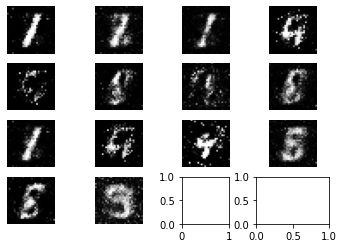

In [12]:
# 컨트롤 타워

# 데이터 준비
x_train = read_data()

# GAN 구현
discriminator, generator, gan = build_GAN()

print(discriminator.trainable)

# GAN 학습
train_GAN()